# Example Parallelized Workflow
This notebook demonstrates how GDTchron uses a parallelized workflow to process large numbers of time-temperature paths quickly. It creates a suite of pseudo-random t-T paths and predicts AHe ages from them using multiple processors, with the number of paths and processors set by the processors available on the system used.

In [1]:
# Imports
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import cmcrameri.cm as cmc

import gdtchron as gdt

The cell below uses the CPU count of the current system to design a test with the number of cores available on the system.

In [2]:
# Set up number of processesors
max_cores = int(os.cpu_count()/2)
print('Maximum cores: ',max_cores)
core_list = [int(2**x) for x in range(max_cores) if 2**x<=max_cores]
print('Cores to run for scaling test: ',core_list)

Maximum cores:  10
Cores to run for scaling test:  [1, 2, 4, 8]


The cell below determines the number of paths to run based on the maximum avaialable cores. It then generates the requisite number of paths by pseudo-randomly picking temperatures between 0°C and 75°C for each 100,000 years from 40 Ma to the present.

In [3]:
# Set number of paths based on max cores
n_paths = max_cores*1500
print('Number of t-T paths: ',n_paths)

# Generate list of pseudo-random t-T paths between 0 and 75 C over 40 Myr
total_time = 40 # Myr
interval = 0.1 # Myr
n_steps = int(total_time/interval)+1
tsteps = np.arange(total_time,0-interval,-interval) # Myr

rng = np.random.default_rng(17)
temp_paths = [rng.uniform(low=273,high=348,size=n_steps) for x in range(n_paths)]

Number of t-T paths:  15000


In [4]:
# Run through AHe
times = []
for cores in core_list:
    print(cores,' cores')
    start = time.time()
    ages = gdt.run_tt_paths(temp_paths=temp_paths,tsteps=tsteps,system='AHe',
                            batch_size=10)
    end = time.time()
    elapsed = end-start
    times.append(elapsed)
    print(cores,': ',elapsed,' seconds\n')

1  cores


100%|██████████| 15000/15000 [01:00<00:00, 246.82it/s]


1 :  62.47962498664856  seconds

2  cores


100%|██████████| 15000/15000 [01:07<00:00, 222.58it/s]


2 :  68.04418706893921  seconds

4  cores


100%|██████████| 15000/15000 [01:02<00:00, 241.59it/s]


4 :  62.740355253219604  seconds

8  cores


100%|██████████| 15000/15000 [01:03<00:00, 236.75it/s]


8 :  64.05808925628662  seconds



In [5]:
# Create array and write to disk for reuse
output = np.array([core_list,times])
np.save('scaling.npy',output)

age_array = np.array(ages)
np.save('scaling_ages.npy',age_array)

In [6]:
# Reload array
output = np.load('scaling.npy')
core_list = output[0]
times = output[1]

ages = np.load('scaling_ages.npy')

In [7]:
# Color and Device
ahe_color = cmc.batlowS.colors[6]
device = 'Tufts HPC Node (Dual Intel Xeon Gold 6448Y)'

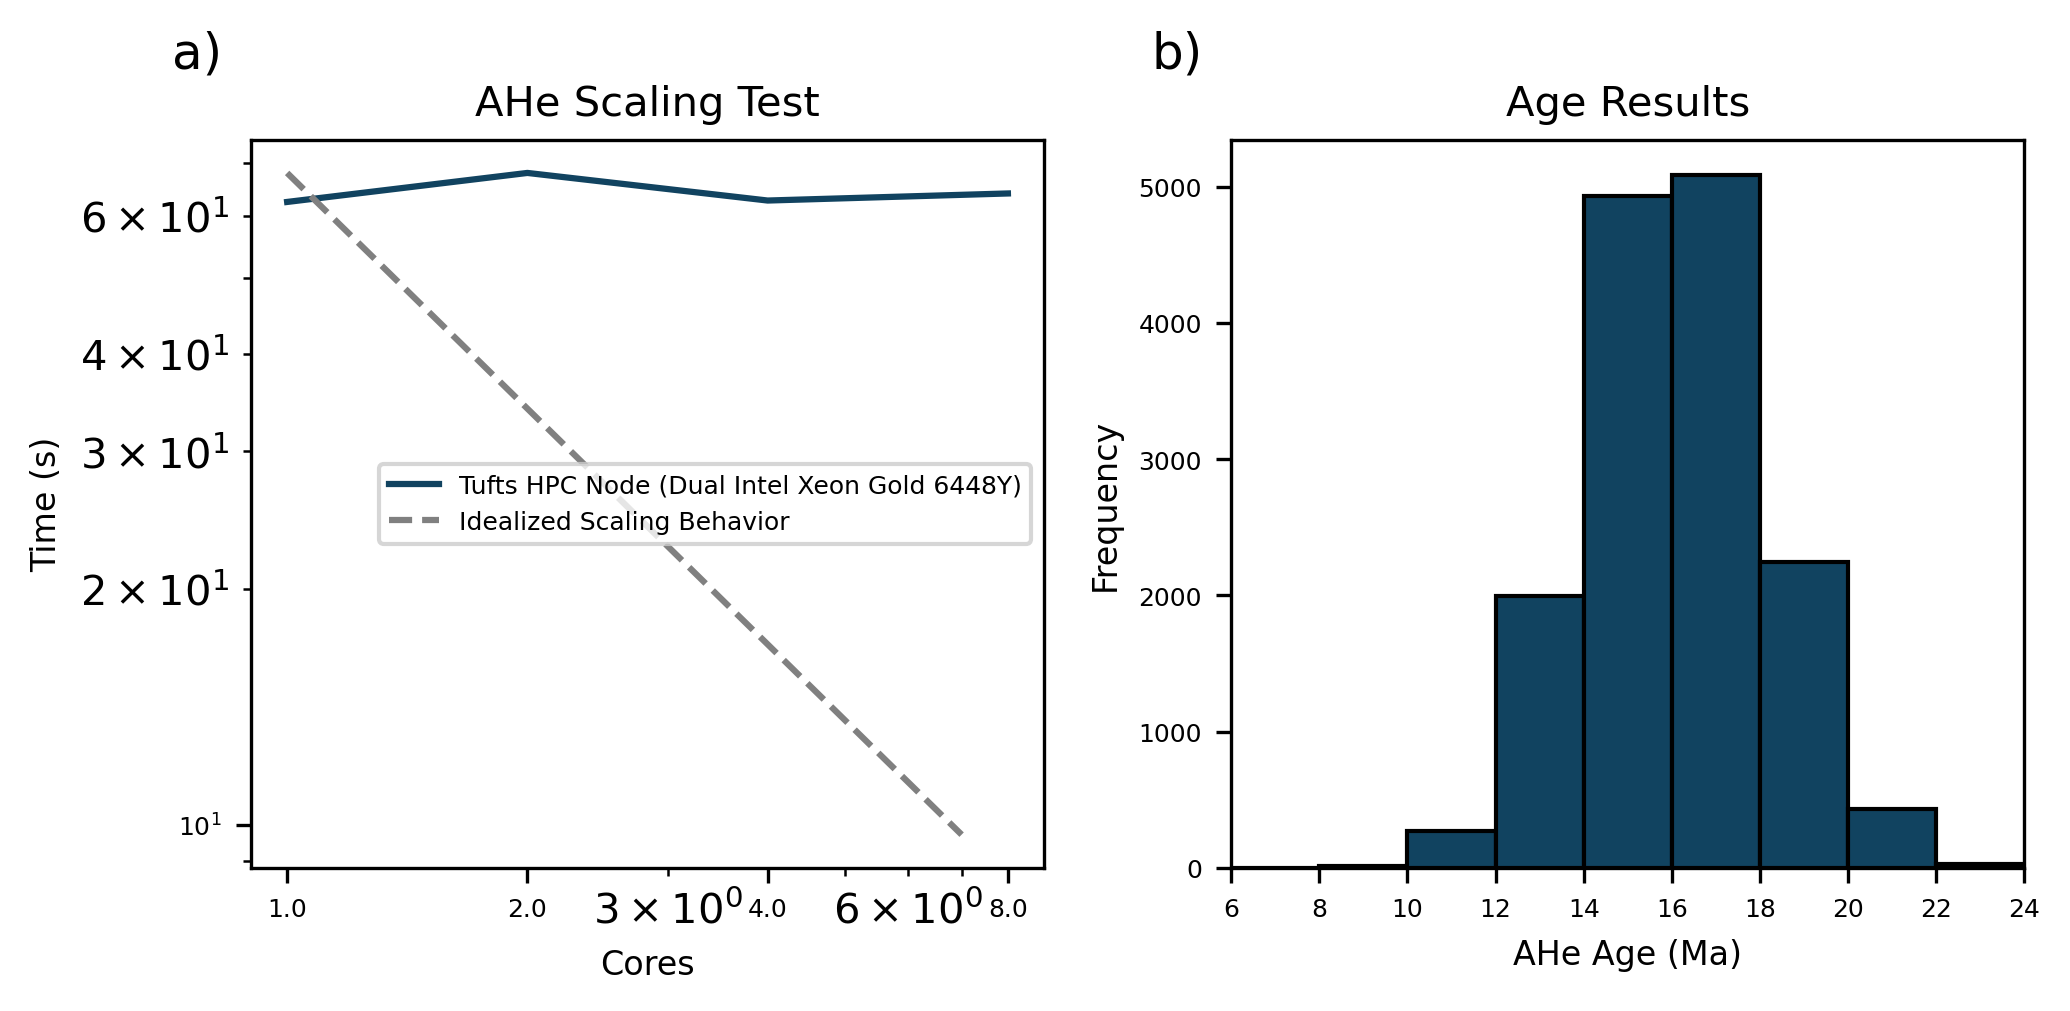

In [8]:
# Plot Scaling Results
fig,axs = plt.subplots(1,2,dpi=300,figsize=(7,3.5))

axs[0].plot(core_list,times,c=ahe_color,label=device)
axs[0].loglog()
axs[0].set_xticks(core_list)
axs[0].set_xticklabels(core_list)
axs[0].set_xlabel('Cores',fontsize=8)
axs[0].set_ylabel('Time (s)',fontsize=8)
axs[0].set_title('AHe Scaling Test',fontsize=10)

ref_x = np.arange(1,max(core_list),1).astype(float)
ref_y = max(times)*ref_x**-1
axs[0].plot(ref_x,ref_y,c='grey',linestyle='--',label='Idealized Scaling Behavior')
axs[0].legend(fontsize=6)

# Plot age results
hist_range=(6,24)
axs[1].hist(ages,color=ahe_color,edgecolor='black',range=hist_range,bins=9)
axs[1].set_title('Age Results',fontsize=10)
axs[1].set_xlabel('AHe Age (Ma)',fontsize=8)
axs[1].set_ylabel('Frequency',fontsize=8)
axs[1].set_xlim(hist_range)

for k,ax in enumerate(axs):
    ax.tick_params(axis='both',labelsize=6)
    ax.annotate(chr(97+k) + ')',(-0.1,1.1),xycoords='axes fraction',fontsize=12) 
plt.tight_layout()
fig.savefig('scaling_test.jpg')
